#Internet-of-Things Classification Challenge
Activity recognition in a home enviornment is an important problem with applications to elder care, safety/security, and home automation. This challenge studies data, models, and techniques that can best leverage camera data to predict activities in a kitchen. The data was collected at the University of Chicago in a mock kitchen. It consists of a series of videos, from multiple angles, of different interactions with smart home devices.

The objective of the first phase of this assignment is to get started with a basic model. You will familiarize yourself with the following: (1) how to access the dataset, (2) how to extract basic features from the dataset, (3) how to train model on these features, and (4) how to submit your results to our model scoring leaderboard.

This first phase will have less flexibility than future ones. We’d like to understand the best we can achieve using only Facebook's VideoPose3D package for featurization. That is, you should not use any other video/image feature, but you are allowed to subsample video frames, and select any subset of 3-D Keypoints from this package as appropriate. While the 3-D keypoint packages also provide ‘confidence’ values for tracking, these are not to be used yet. 

### Setup 1. Accessing The Dataset
All of data is organized in a hierarchy of directories in google drive. Your instructors will give you acceess to this drive. All of the data is located in this folder:

https://drive.google.com/drive/folders/1EYJsSZ1d-ms_S_J-5NPz7GwUb4ZHN5ZM?usp=sharing

* The first thing that you need to do is to create a shortcut to this shared folder in your drive. You can do so by clicking on the folder name at the top and adding a shortcut. 

* Also, make sure that your notebook is connected to a GPU. You can do this by clicking the RAM and DISK link in the upper right hand corner and connect the notebook to a hardware accelerator.

* Next, run the following code that mounts your drive to the collab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Once you mount the drive, you should be able to access the directory as you would in standard Python

In [ ]:
import os
os.listdir('/content/drive/My Drive/IOT Classification Challenge/')

['Dataset_1', 'VideoPose3D', 'Evaluation_Dataset']

Initially, this directory has three subdirectories. Dataset_1 is the dataset that you will be using for training your classification models, VideoPose3D contains the pretrained neural networks to construct the features, and Evaluation_Dataset contains a set of unlabled videos for evaluation. 

Let's see how the training dataset is structured. The first set of subdirectories refer to devices. In this first phase, we will focus on the *refrigerator*.

In [ ]:
PATH = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/'

os.listdir(PATH)

['.DS_Store', 'alexa', 'nestcam', 'log', 'refrigerator']

Let's now see how the actual data is structured. The first level of folders divides the demonstrations for the device into individual activities (the classes you will predict!). There should be *5* different folders:

In [ ]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'

os.listdir(DATASET)

['put_back_item',
 'open_close_fridge',
 'screen_interaction',
 'take_out_item',
 'no_interaction']

Next, we will extract the individual demonstrations from this dataset. Inside each activity sub-directory is a demonstrator sub-directory (named with a demonstrator). These indicate who provided the demonstration in question. Entering this directory gives you access to the raw data needed for this assignment.

The following code helps visualize what is going on. It uses the python "glob" package to recursively traverse the directories and extract all of the data files.

In [ ]:
from glob import glob
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.*'))]
result[:10]

['/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_2_1613086149_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_2.mkv',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253.wav',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_1_1613086093.wav',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200.wav',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253_1.mp4',
 '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_

Let's take the file 'put_back_item_2_1613086149_1.mp4' as an example. Each demonstration has an id number. In this case, it would be '1613086149'. This number uniquely identifies the demonstration throughout the dataset. For each demonstration there are three files "_1.mp4", "_2.mkv", and ".wav". The mp4 files are videos of a front-view camera angle of the demonstration. The mkv files are a side-view camera angle. The wav files are an audio recording of the demonstration. **In this phase, you will only be using the mp4 files**

The following code will help you get started. It creates a labeled dataset of (activity, mp4_file_path):

In [ ]:
def initialize_dataset():
  result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]
  labels = [r.split('/')[7] for r in result]
  return list(zip(labels, result))

initialize_dataset()[:10]

[('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_2_1613086149_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_3_1613086200_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_4_1613086253_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_5_1613086310_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/1/put_back_item_1_1613086093_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/put_back_item/4/put_back_item_7_1616180920_1.mp4'),
 ('put_back_item',
  '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/pu

## Setup 2. Working with Video Data
Conceptually, video can be thought of as a sequence of imagees (called frames). Each frame is a 3D array containing Red, Green, and Blue pixels. OpenCV is a library of programming functions mainly aimed at real-time computer vision and is one of the primary tools that you will use to process video data. The following code shows how to extract and visualize one frame from a video. The code below also shows examples of the necessary error handling that is needed to work with real-world video data.

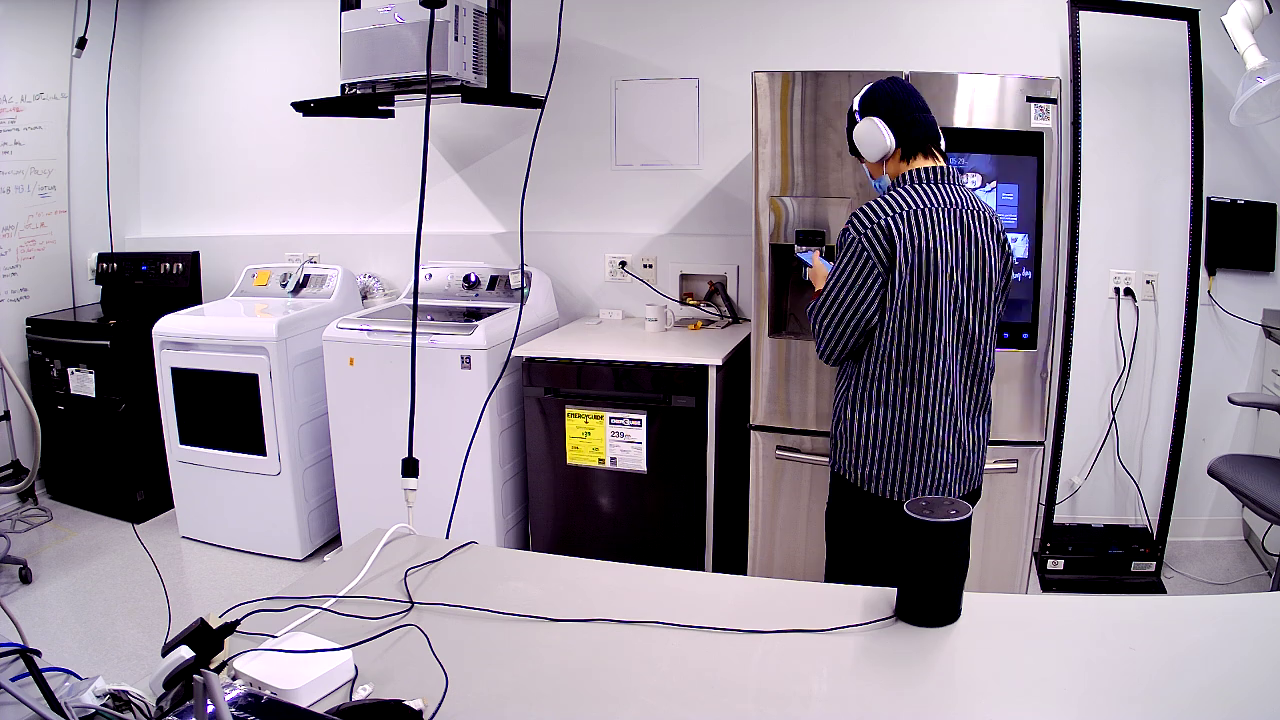

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

label, path = initialize_dataset()[0] #get first video

cap = cv2.VideoCapture(path) #open the video
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    cv2_imshow(frame)
    break



We can also look at each individual frame to get a better understanding of the data. Each frame is a 720x1280x3 numpy array:

In [ ]:
frame.shape

(720, 1280, 3)

As a more complicated example, the following code aggregates the first 100 frames into a 4D numpy array (i.e., stacks each frame into a single array):

In [ ]:
import numpy as np
cap = cv2.VideoCapture(path) #open the video

cnt = 0
framelist = []

while(cap.isOpened()):
  ret, frame = cap.read()

  if cnt >= 100:
    break

  if ret == True:
    framelist.append(frame)
  else:
    raise ValueError('Video malformated or too short')
  
  cnt += 1

first_100_frames = np.stack(framelist)
first_100_frames.shape


(100, 720, 1280, 3)

## Setup 3. VideoPose3D
In the first phase, you will use pretrained models from Facebook's VideoPose3D library:
https://github.com/facebookresearch/VideoPose3D
The library takes as input videos of human activities, identifies "keypoints" on the human body, and estimates the 3D position of those keypoints. 

The first step is to install all of the prerequisites.


In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 573 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 14.6 MB/s 
  Created wheel fo

After, installing the pre-requisites we will demonstrate how to use VideoPose3d. The following code changes directories into the VideoPose3d folder and runs inference on a demo video.

In [ ]:
%cd /content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/

/content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference


We've placed one demo video in the VideoPose3D folder and the following code runs inference on that video. It takes about 2 mins to complete.

In [ ]:
!python infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir outputs \
    --image-ext mp4 \
    inputs/

model_final_997cc7.pkl: 313MB [00:12, 24.1MB/s]               
Processing inputs/test.mp4
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-l

After running this code, the outputs are stored in the output folder.

In [ ]:
%cd /content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/outputs
os.listdir('.')

/content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/outputs


['test.mp4.npz']

These outputs can be loaded into numpy as a standard numpy array. We will show a brief tutorial of how to use this data structure.

In [ ]:
data = np.load('test.mp4.npz',allow_pickle=True)
for d in data.files:
  print(d)

boxes
segments
keypoints
metadata


The main features that we want you to work with are keypoints. The API is a little difficult to use so we have some demo code to retrieve the keypoints

In [ ]:
def extract_trajectories(keypoints):
  trajectory = []
  for _,k in keypoints:
    if len(k) !=0: #removes data where nothing is happening
      three_d_point = k[0,[0,1,3],:] #understand this code!!! look it up in the documentation
      trajectory.append(three_d_point)

  return trajectory


traj = extract_trajectories(data['keypoints'])

There are 17 keypoints and each keypoint is a 3d point in space. For example, to grab the first time-step, we get the following 3x17 vector

In [ ]:
traj[0]

array([[1.2498834e+03, 1.2537076e+03, 1.2527516e+03, 1.2728293e+03,
        1.2747416e+03, 1.2690051e+03, 1.2565759e+03, 1.2508394e+03,
        1.2288495e+03, 1.1829574e+03, 1.2517955e+03, 1.2690051e+03,
        1.2212008e+03, 1.2623125e+03, 1.2345859e+03, 1.1810453e+03,
        1.1800891e+03],
       [1.3659172e+02, 1.2892342e+02, 1.2988196e+02, 1.4521857e+02,
        1.4138441e+02, 2.5353342e+02, 2.5257489e+02, 4.0402396e+02,
        4.3469717e+02, 5.6218280e+02, 5.5115959e+01, 2.4394804e+02,
        5.9189746e+02, 3.7335074e+02, 4.2511179e+02, 5.6793402e+02,
        5.6793402e+02],
       [9.3154825e-02, 1.5066859e-01, 1.0222106e-01, 1.6204618e-01,
        1.1094550e-01, 9.0640984e-02, 7.4473597e-02, 2.8256804e-02,
        3.9042279e-02, 8.7577961e-02, 6.2662661e-02, 8.6169681e-03,
        1.0698050e-02, 7.6038321e-03, 1.0091187e-02, 2.8308829e-02,
        4.2222373e-02]], dtype=float32)

We can plot one of the dimensions over time to understand how the data looks. For example, the following code plots the 2 of the key point dimensions on a plane

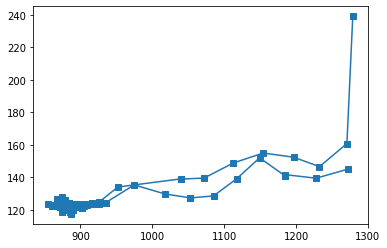

In [ ]:
import matplotlib.pyplot as plt

plot_data = np.stack(traj)
plt.plot(plot_data[:,0,3],plot_data[:,1,3], 's-')
#plot_data.shape

To get this to work on your own notebook, you will have to download the facebook repository and put it in your own google drive. This has to do with "write" permissions.

## TODO 1. Preprocessing
Video activity classification is much easier if all of the videos have the same number of frames. However, notice that the data that we gave you has videos of different lengths.  

Your first TODO is to write a preprocessing function that iterates through all of the videos and subsamples the frames to keep only 100 of them per video. The function should store these subsampled videos in a separate directory. 

You may subsample the video in any way you choose. You may also handle videos shorter than a 100 frames in any way you choose (i.e., blank frames or duplicate the last frame).

This tutorial on writing videos with OpenCV should be helpful:
https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

In [ ]:
def preprocess():
  '''Preprocess(): subsample video frames in any way you choose, subsampling can improve computation time
        Input: Iterate through the directory of videos
        Output: Stores a subsampled video for each in the directory that only contains a 100 frames
  '''
  #your code here
  pass

## TODO 2. Featurization
In the next step, you will write a function that applies the VideoPose3D model to each subsampled video. The example above will help you understand how to use the library and what the outputs are. The output should be a directory of .npz files corresponding to the features. 

In [ ]:
def featurize():
  '''Featurize: design final feature vector after 3-D keypoints processing.  Select only the hand.
      Input: a directory of subsampled video
      Output: store the output in a directory of .npz files for each video

  '''
  #your code here
  pass

## TODO 3. Create a Dataset
Next, you will aggregate all of this preprocessed data into numpy arrays that can be used for machine learning. You will now create a training dataset and validation dataset. 

Hint: the tricky part here will be to make sure you can figure out what the label for the file should be!


In [ ]:
def create_dataset():
  ''' CreateDataset: creates a training dataset and validation dataset
        Input: Directory with a collection of vectors of fixed dimension for each video
        Output: A training set (X_train,Y_train), a validation (X_test, Y_test)
  '''
  return (None, None), (None, None)

## TODO 4. Train a Classifier
In this step, you will train a classification model using the datasets aggregated in the previous step. You may use any model type that you wish (this part is flexible!). You may also use any helper fuctions to do model or parameter search.

In [ ]:
def train_classifier(Xtrain, Ytrain, Xtest, Ytest):
  '''Input: Dataset (n vectors X_i and their labels) that is split into training and test. 
     Output: Model (of whatever family), whatever the suitable format to make predictions.
  '''
  return None

## TODO 5. Submit Challenge Predictions
Finally, we have provided a test set with unlabeled data in the 'Evaluation_Dataset' folder. We have the appropriate labels for this dataset (that you can't see!). You will be ranked on your performance on this dataset. 

Write a function that iterates through all of the videos in the evaluation dataset, preprocesses them, featurizes them, and then issues a prediction. You will have to figure out how to encapsulate your code to make this easy to do without having to duplicate functions. The output should be dictionary of demonstration id to predicted label.

In [ ]:
def featurize_evaluation_set():
  '''Input: a directory of videos corresponding to the evaluation dataset
     Output: a dictionary mapping demonstration id -> feature vector
  '''
  return {}


def eval_model(model, eval_features):
  '''Input: a model, and a dictionary mapping demonstration ids -> feature vector
     Output: a dictionary mapping demonstration id -> predicted labels
  '''

  return {}

In [ ]:
#Helper function for eval_model to ensure prediction labels generated in correct order:
#Get list of evaluation data filepaths in same order as held out y test data.
def get_correctly_ordered_prediction_filelist():
        import os
        PATH = '/content/drive/MyDrive/IOT Classification Challenge/Evaluation_Dataset'

        filelist=[]
        for root, dirs, files in os.walk(os.path.abspath(PATH)):
            for file in files:
                filelist.append(os.path.join(root, file))

        filelistunordered=[]
        for i in filelist:
          if '.mp4' in i:
              filelistunordered.append(i)

        filelist_evalids=[]
        for i in filelistunordered:
          splitfilelist=i.split("_")
          filelist_evalids.append(int(splitfilelist[len(splitfilelist)-2]))

        filelist_evalids.sort()

        predictionfiles=[]
        for i in filelist_evalids:
          for j in filelistfinal:
            if j.find(str(i))>0:
              predictionfiles.append(j)
        return predictionfiles


predictionfiles=get_correctly_ordered_prediction_filelist()

# Putting it all together
Your program can use as many helper functions and subroutines as you need but it should follow this rough sequence.

In [ ]:
preprocess()
featurize()
Training, Test = create_dataset()
clf = train_classifier(Training[0], Training[1], Test[0], Test[1])

eval_features = featurize_evaluation_set()
predicted_labels = eval_model(clf, eval_features)

#### Submit prediction_labels to live leaderboard

In [ ]:
#Install aimodelshare Python library
! pip install aimodelshare --upgrade

In [ ]:
# Submit prediction labels to leaderboard (Requires username and password from modelshare.org):

import aimodelshare as ai

#Instantiate Competition and insert modelshare.org username/password to set your competition credentials
apiurl='https://0fv18x6hfi.execute-api.us-east-1.amazonaws.com/prod/m'

mycompetition= ai.Competition(apiurl)

#input your username and password
from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


#### Here are some randomly generated prediction labels just to see how submission works 
(Replace this prediction_label list with your own predictions for actual submission!)

In [ ]:
#Example prediction_labels for practice submission (replace with your own prediction list for real submissions!)

prediction_categories=['screen_interaction', 'take_out_item', 'put_back_item', 'no_interaction', 'open_close_fridge']

import random
predicted_labels=random.choices(prediction_categories, k=49)


In [ ]:
# Submit Model predictions to Competition Leaderboard
mycompetition.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=predicted_labels)

Insert search tags to help users find your model (optional): random submissions #2
Provide any useful notes about your model (optional): random submission list number 2

Your model has been submitted as model version 4

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1354


In [ ]:
# Submit Model with custom leaderboard data

# Custom metadata can be added by passing a dict to the custom_metadata argument of the submit_model() method
# This option can be used to fill in missing data points or add new columns to the leaderboard

custom_meta = {'team': 'one',
               'model_type': 'your_model_type',
               'new_column': 'new metadata'}

mycompetition.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels,
                                 custom_metadata = custom_meta)

In [ ]:
# View current leaderboard (or go to competition tab here: https://www.modelshare.org/detail/model:1354)
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,deep_learning,model_type,model_config,dense_layers,depth,loss,lstm_layers,memory_size,num_params,optimizer,softmax_act,tanh_act,username,version
1,38.78%,30.20%,40.91%,32.04%,unknown,nan,unknown,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,IOTStatsResearch,1
2,38.78%,30.20%,40.91%,32.04%,keras,1.000000,Sequential,"{'name': 'sequential', 'layers...",1.000000,4.000000,str,3.000000,13558952.000000,9881459.000000,RMSprop,1.000000,3.000000,IOTStatsResearch,2
3,24.49%,24.45%,25.33%,24.44%,unknown,nan,unknown,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,newusertest,4
4,18.37%,17.48%,17.49%,18.22%,unknown,nan,unknown,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,IOTStatsResearch,3


In [ ]:
# Compare two or more models (Experimental, Git-like Diffs for Model Architectures)
#note: this is built to use with models submitted that point to a preprocessor file and a model file (i.e.-not set to None.)
data=mycompetition.compare_models([1,2],verbose=1)
mycompetition.stylize_compare(data)



,param_name,default_value,model_version_1


,Model_2_Layer,Model_2_Shape,Model_2_Params
0,LSTM,"[None, 100, 50]",9840600
1,LSTM,"[None, 100, 50]",20200
2,LSTM,"[None, 50]",20200
3,Dense,"[None, 9]",459
